# NLP project for Codecademy by Elena Lebedeva

In this project, we will be analyzing text message data using Natural Language Processing techniques and libraries.

Project Objectives:
- Work locally using own machine
- Import and look over dataset
- Conduct text-preprocessing.
- Plan and conduct any number of NLP techniques to analyze and gain insight into the data.

These techniques can include:
- Language Parsing
- Word Vectorization
- Language Modeling
- Topic Modeling
- Checking Similarity
- Sentiment Analysis
- POS Tagging
- Named Entity Recognition

### Importing and looking over dataset

We start from improting libraries, dataset and analysing the getting the notion how is dataset is organized and if it needed to be cleaned.

In [37]:
import numpy as np
import pandas as pd
import nltk   
import matplotlib.pyplot as plt

import re                                  # library for regular expression operations
import string                              # for string operations

from collections import Counter

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize, sent_tokenize 
from nltk import ngrams                    # module for tokenizing strings
from wordcloud import WordCloud
from nltk import pos_tag, RegexpParser    #  to pasre and tag the parts of speech
stop_words = nltk.corpus.stopwords.words('english')

In [3]:
df = pd.read_csv('clean_nus_sms.csv')

In [4]:
df.sample(10)

,Unnamed: 0,id,Message,length,country,Date
44063,50417,40301,Lolwtf where btw,16,Singapore,2011/12
31586,34740,24624,Eh? Haha it's okay le.,22,Singapore,2011/4
14508,15673,5557,Its k..,7,India,2011/1
14910,16169,6053,Hi da:)how is the todays class?,31,India,2011/2
47640,54715,44599,Well I love you =),18,USA,2014/9
48178,55380,45264,hai da... see u tommorow,24,INDIA,2014/11
43118,49438,39322,Nope! Tmr how ah!,17,Singapore,2011/12
9894,10230,114,U didnt lyk dat i askd coding only na,37,India,2010/11
1591,1642,11762,s up...,7,SG,2003/4
26267,28981,18865,"i take one as breadth, the other as gek lor.U ...",125,Singapore,2011/3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48598 entries, 0 to 48597
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48598 non-null  int64 
 1   id          48598 non-null  int64 
 2   Message     48595 non-null  object
 3   length      48598 non-null  object
 4   country     48598 non-null  object
 5   Date        48598 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


In [47]:
pd.DataFrame(round((df.isna().mean()*100),3)).style.background_gradient(cmap='Blues').format('{:.4f}')

,0
Unnamed: 0,0.0000
id,0.0000
Message,0.0000
length,0.0000
country,0.0000
Date,0.0000
month_year,0.0000
Message_processed,0.0000


We have almost 50K row of data on SMS with the information on its id, length, country, date and message itself. As our main interest is the text data, we will delete the rows where text is empty. 

In [46]:
df = df.dropna(subset=['Message', 'length'])

In [48]:
df.duplicated().sum()

0

We have no dublicates and next step is to change some datatypes to the appropriate ones, such as length and date, as initially they have type 'object'.

In [49]:
df['length']= pd.to_numeric(df['length'], errors='coerce')

In [50]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m').dt.strftime('%m/%Y')
df['Date'] = pd.to_datetime(df['Date'])

In [51]:
df['country'].value_counts().head(10).to_frame().style.background_gradient(cmap='Blues')

,country
Singapore,31814
India,7085
United States,5679
Sri Lanka,1047
Malaysia,767
Pakistan,751
unknown,602
Canada,198
Bangladesh,126
China,107


We have some contry names written in a different way, let's change it so we can correctly count the sms amount per country.

In [52]:
df.loc[df['country'] == 'SG', 'country'] = 'Singapore' 
df.loc[df['country'] == 'USA', 'country'] = 'United States' 
df.loc[df['country'] == 'india', 'country'] = 'India' 
df.loc[df['country'] == 'INDIA', 'country'] = 'India' 
df.loc[df['country'] == 'UK', 'country'] = 'United Kingdom' 
df.loc[df['country'] == 'srilanka', 'country'] = 'Sri Lanka' 
df.loc[df['country'] == 'MY', 'country'] = 'Malaysia' 

Let's check top-10 country by SMS amount in our dataset. We can see that by far they are from Singapore, but India and USA are represented numerously.

In [53]:
top_ten = df['country'].value_counts().head(10)
top_ten.to_frame().style.background_gradient(cmap='Blues')

,country
Singapore,31814
India,7085
United States,5679
Sri Lanka,1047
Malaysia,767
Pakistan,751
unknown,602
Canada,198
Bangladesh,126
China,107


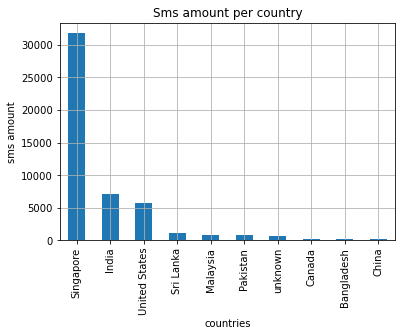

In [54]:
top_ten.plot.bar(grid=True, title="Sms amount per country", legend=False
)
plt.xlabel('countries')
plt.ylabel('sms amount')
plt.show()

Let's see the distribution of the SMS length.

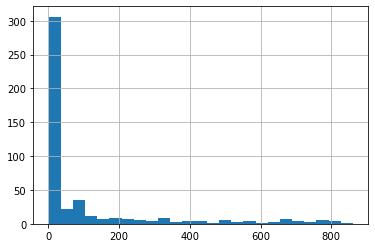

In [55]:
df['length'].value_counts().hist(bins=25)
plt.show() 

The vast mayority of SMS are less than 200 characters, which is understandable. A single SMS message technically supports up to 160 characters.

In [56]:
pd.cut(df['length'], bins=5).value_counts()

(0.091, 182.8]    47280
(182.8, 364.6]     1159
(364.6, 546.4]      128
(546.4, 728.2]       18
(728.2, 910.0]        6
Name: length, dtype: int64

Let's take a look on the timeline of our data.

In [57]:
df['Date'].min()

Timestamp('2003-04-01 00:00:00')

In [58]:
df['Date'].max()

Timestamp('2015-03-01 00:00:00')

We have sms from April 2003 till March 2015.

In [59]:
# creting additional column with month and year information and checking periods with highest amount
df['month_year'] = pd.to_datetime(df['Date']).dt.to_period('M')
df['month_year'].value_counts().head(10).to_frame().style.background_gradient(cmap='Blues')

,month_year
2011-03,10434
2003-04,9804
2011-04,5752
2011-12,5597
2011-11,4040
2011-01,3647
2011-02,3633
2014-09,2322
2010-11,917
2010-12,562


The highest amount of SMS we have in March 2022, it is 10 K, so around 20% of all, this month is followed by April 2003 with the similar amount and other months and years would have less representation, some months within the period has no data, as we can see in the plot below. 

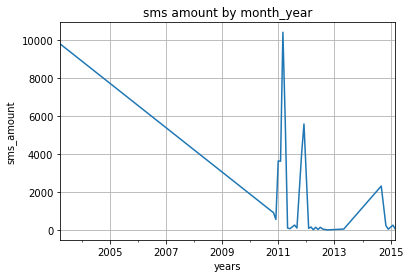

In [60]:
df.groupby('month_year')['country'].agg(['count']).plot(
    grid=True, title="sms amount by month_year", legend=False
)
plt.xlabel('years')
plt.ylabel('sms_amount')
plt.show()

If we take a look on the average lenght of SMS by country, the longest SMS in dataset are from Canada and Sri Lanka, with around 100 characters, meanwhile Singapore and USA have around 55.

In [61]:
count_by_sms_length = df.groupby('country')['length'].agg(['count' ,'mean']).sort_values(by='mean',ascending=False)
count_by_sms_length.head(10).style.background_gradient(cmap='Blues').format('{:.2f}')

,count,mean
country,,
Canada,198.00,103.78
Sri Lanka,1047.00,94.49
Macedonia,10.00,92.20
Ghana,18.00,73.50
Singapore,31814.00,56.00
Nigeria,10.00,54.60
United States,5679.00,53.98
China,107.00,53.65
Malaysia,767.00,51.25


The countris with the shortest SMS are Morocco with 10 characters, New Zeland and Nepal with 18. However, the amount of SMS from these countries is very low.

In [62]:
count_by_sms_length.tail(5).style.background_gradient(cmap='Blues').format('{:.2f}')

,count,mean
country,,
Serbia,22.00,25.00
Turkey,10.00,24.20
Nepal,39.00,18.44
New Zealand,10.00,18.10
Morocco,9.00,11.78


Now that we have looked at our dataset and cleaned it a littele bit, let's start working with SMS messages text data from SMS.

# Preprocess raw text

Let's preprocess our text messages into cleaned stemmed words.

In [63]:
# this function will preprosee the raw data

def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split into words -> convert string into list ( 'hello world' -> ['hello', 'world'])
    words = letters_only_text.lower().split()
    
    stemmer = PorterStemmer()

    # stemmer
    stemmed_words = []
    for word in words:
        if word not in stop_words:
            word = stemmer.stem(word)
            stemmed_words.append(word)
    
    # converting list back to string
    return " ".join(stemmed_words)

Testing our function in one message: it will remove numbers, punctuation, capital letters, stop words, "chop" words into stemmed words (so, for example, singular and plural forms of the same word will be the same).

In [64]:
test_sentence = df['Message'][2]
print(test_sentence)
print(preprocess(test_sentence))

I dunno until when... Lets go learn pilates...
dunno let go learn pilat


We gonna create a new column with the copy of texts and will apply the preprocess function to it, so the original sms are kept in case we need them.

In [65]:
df["Message_processed"] = df["Message"]
df["Message_processed"] = df["Message_processed"].apply(preprocess)

In [66]:
df.sample(5)

,Unnamed: 0,id,Message,length,country,Date,month_year,Message_processed
25961,28670,18554,Haha..kk.. where u all eating? Can I join?:p,44.0,Singapore,2011-03-01,2011-03,haha kk u eat join p
47547,54592,44476,Why are you up? Lol,19.0,United States,2014-09-01,2014-09,lol
34960,38466,28350,why you didn't text me yesterday,32.0,India,2011-08-01,2011-08,text yesterday
42247,48487,38371,Ohh ~ I fell asleep hahaha ohh then how!,45.0,Singapore,2011-12-01,2011-12,ohh fell asleep hahaha ohh
48252,55457,45341,hows the class n all going,26.0,India,2014-12-01,2014-12,how class n go


Now we have a column with preprocessed sms texts, we will create out of it some lists with diferent structures o, as we will need them to work later.

In [70]:
# this is one list of list with tokens from sms (each list inside list is a sms)
list_tokenized_sentences = []
for i in range(len(df['Message_processed'])):
        try: 
            tokenized_sentence =df['Message_processed'][i].split()
            list_tokenized_sentences.append(tokenized_sentence)
        except: 
            continue

In [71]:
list_tokenized_sentences[:3]

[['bugi', 'oso', 'near', 'wat'],
 ['go',
  'jurong',
  'point',
  'crazi',
  'avail',
  'bugi',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet',
  'cine',
  'got',
  'amor',
  'wat'],
 ['dunno', 'let', 'go', 'learn', 'pilat']]

In [75]:
# this is one list made of all tokens from sms (each element is a tokenized word)
list_tokenized_words = " ".join(df["Message_processed"]).split()
list_tokenized_words[:10]

['bugi',
 'oso',
 'near',
 'wat',
 'go',
 'jurong',
 'point',
 'crazi',
 'avail',
 'bugi']

In [76]:
# this is one list where each element is tokenized sms 
sms_one_list = df["Message_processed"].tolist() 
sms_one_list[:3]

['bugi oso near wat',
 'go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'dunno let go learn pilat']

In [78]:
# this is the whole corpus of all sms all together as if it was one written piece
sms_all_string = " ".join(sms_one_list) # all sms together as if it was one text
sms_all_merged = []
sms_all_merged.append(sms_all_string)
# sms_all_merged in one string, it will starts such as this:
# >> ['bugi oso near wat go jurong point crazi avail bugi n great world la e buffet cine got amor wat dunno let go learn pilat

## NATURAL LANGUAGE PARSING WITH REGULAR EXPRESSIONS
### Chunking

Chunking is used to see the specific grammar structures which can provide us with insights on the text data. To perform it, we have to tag each word with it's part of the speech, search for the specific structure using Regular Expression and count them so we can see the frequency.

So let's tag all the tokens with it's part of the speech.

In [79]:
# nltk.download('averaged_perceptron_tagger') - this can be needed

# create a list to hold part-of-speech tagged (pos) sentences here
pos_tagged = pos_tag(list_tokenized_words) # list_tokenized_words
pos_tagged[:7]

[('bugi', 'NN'), ('oso', 'NN'), ('near', 'IN'), ('wat', 'NN'), ('go', 'VBP')]

NN means noun, VB is a verb form, JJ is adjective, etc. 
Full alphabetical list of part-of-speech tags :
https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [84]:
# function that pulls chunks out of chunked sentence and finds the most common chunks

def chunk_counter(chunked_sentences):
    # create a list to hold chunks
    chunks = []

    # for-loop through each chunked sentence to extract noun phrase chunks
    for chunked_sentence in chunked_sentences:
        for subtree in chunked_sentence.subtrees(filter=lambda t: t.label() == 'Chunk'):
            chunks.append(tuple(subtree))

    # create a Counter object
    chunk_counter = Counter()

    # for-loop through the list of chunks
    for chunk in chunks:
        # increase counter of specific chunk by 1
        chunk_counter[chunk] += 1

    # return most frequent chunks
    return chunk_counter.most_common(20)

def chunking(chunk_grammar):
    # create RegexpParser object
    chunk_parser = RegexpParser(chunk_grammar)

    # create a list to hold chunked sentences
    chunked_sent = []

    # chunk each sentence and append to chunked_sms
    chunked_sent.append(chunk_parser.parse(pos_tagged))

    # store and print the most common chunks
    most_common_chunks = chunk_counter(chunked_sent)
    chunks_counter_df = pd.DataFrame (most_common_chunks, columns = ['chunk', "frequency"])
    return chunks_counter_df


Now we have a functrion to pull chunks, we will try several different grammatical structures: verb phrase, noun phrase and a bit more complex verb phrase.

In [85]:
#  verb phrase
# <VB.*> ensures matching verbs of any tense 
# (ex. VB for present tense, VBD for past tense, or VBN for past participle)

chunk_grammar = "Chunk: {<VB.*><DT>?<JJ>*<NN><RB.?>?}"
chunking(chunk_grammar)

,chunk,frequency
0,"((go, VBP), (home, NN))",140
1,"((take, VBP), (care, NN))",70
2,"((take, VB), (care, NN))",66
3,"((reach, VBP), (home, NN))",50
4,"((come, VBN), (home, NN))",43
5,"((got, VBD), (time, NN))",35
6,"((go, VBP), (shop, NN))",31
7,"((want, VBP), (eat, NN))",28
8,"((go, VB), (home, NN))",28
9,"((want, VBP), (meet, NN))",28


In top 20 verb phrese from our SMS we can observe, that people mainly use it to communicate the information (or ask for it) about about going home (several verbs such as come, go, reach are used), they express quite a lot wishing to take care. Also we can see frequent chunks about geting time, going shopping and eating,  meetings/seeing proposals, going to school or getting a job. It shows an instrumental use of SMS for notifiyng, asking and offering. 

In [86]:
# noun phrase (possible determiner, adjective or several, noun)
chunk_grammar = '''Chunk: {<DT>?<JJ>+<NN>}'''
chunking(chunk_grammar)

,chunk,frequency
0,"((u, JJ), (r, NN))",191
1,"((new, JJ), (year, NN))",147
2,"((next, JJ), (time, NN))",120
3,"((u, JJ), (wan, NN))",114
4,"((good, JJ), (night, NN))",110
5,"((wat, JJ), (time, NN))",107
6,"((next, JJ), (week, NN))",94
7,"((u, JJ), (reach, NN))",93
8,"((last, JJ), (time, NN))",74
9,"((good, JJ), (morn, NN))",72


The close look to the noun phrases shows us different picture. We observe high frequncy of noun phrases to express the wish and desire: for the new year (most probably used in congratulations), good night and good morning wishes, also good luck wishes.  next time or next week indicates discuss of the future plans, wat (probably what) time is an instrumental questions relating to meetings and gatherings. 
We observe use of "u" in the noun phrases, which are supposed to show non and adjective."U" is actually used to saying 'you', but our instrument is not sensitive to the slang or informal use.

In [87]:
# The inverted brackets }{ indicate which parts of speech you want to filter from the chunk. 
chunk_grammar = '''Chunk: {<VB.*><DT>?<JJ>*<NN><RB.?>?}
}<DT|IN|RB|CC>+{
'''
chunking(chunk_grammar)

,chunk,frequency
0,"((go, VBP), (home, NN))",157
1,"((take, VB), (care, NN))",73
2,"((take, VBP), (care, NN))",72
3,"((reach, VBP), (home, NN))",54
4,"((come, VBN), (home, NN))",44
5,"((go, VB), (home, NN))",40
6,"((got, VBD), (time, NN))",35
7,"((want, VBP), (eat, NN))",32
8,"((go, VBP), (shop, NN))",31
9,"((go, VBP), (eat, NN))",31


Here we have changed slightly the verb phrase structure using filtering, so we can see the frequencies have increased comparing to the first version. However the insights are similar to what we have already noted.

##  BAG-OF-WORDS LANGUAGE MODEL
### Word frequency

Now let's se the word frequency for one word, two words (bi-grams) and three words (three-grams).

First, let's check which are the most frequent words in our preprocessed sms text corpus.

In [88]:
#let's check the most common words in the dataframe
word_counter_list = Counter(list_tokenized_words).most_common(25)
word_counter_df = pd.DataFrame (word_counter_list, columns = ['word', "frequency"])
word_counter_df.style.background_gradient(cmap='Blues')

,word,frequency
0,u,10299
1,haha,7009
2,go,4921
3,lol,3540
4,got,2548
5,ok,2441
6,time,2192
7,come,2051
8,hahaha,1822
9,okay,1741


Most used words are non-cleaned informal versions "u" and "ur". They can be manually added to stopwords if we would like to exclude them.
Other top words are "haha", "lol" and similar expressions of laugh, "ok", "yeah" and similar for agrement, and most used in everydaylife verbs such as "go", "get", "come", "meet", "think", "like", "want". Plus, noun "time" and adjective "good" are among top 20.

Let's have a visual representation called wordcloud of those top frequent SMS words.

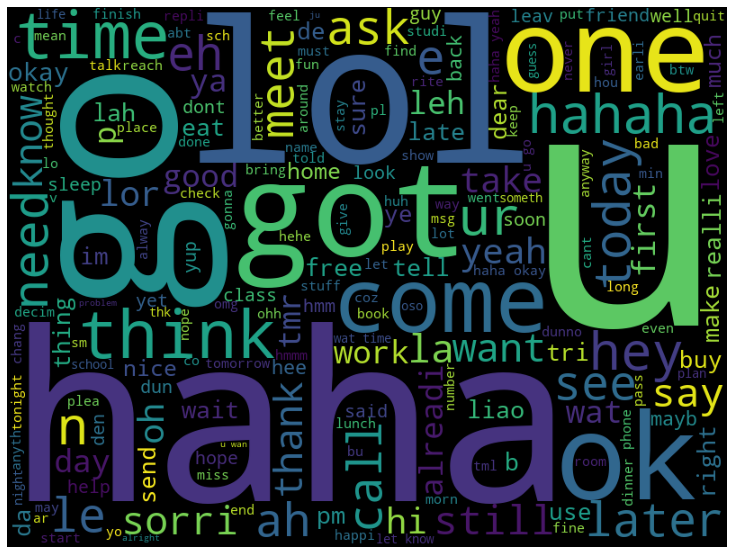

In [89]:
wordcloud = WordCloud(width = 800, height = 600, background_color ='black', min_font_size = 10).generate(sms_all_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Now, let's take a look to the two tokens (processed words) which go togehter. 

In [90]:
# checking  most common bi-grams (two words)
n_gram = 2
n_gram_dic = dict(Counter(ngrams(list_tokenized_words, n_gram)))
bigrams=pd.DataFrame.from_dict(n_gram_dic, orient='index', columns=['count']).sort_values(by='count', ascending=False).head(25)
bigrams

,count
"(r, u)",387
"(haha, okay)",376
"(u, go)",335
"(haha, yeah)",288
"(wat, time)",238
"(u, r)",235
"(let, know)",234
"(u, wan)",231
"(go, home)",207
"(love, u)",204


Due to the nature of SMS, we can see that topest bi-grams (two tokens) are not the most meaningfull. However, it speaks a lot about the sms, they are short messages which, a part of instrumental information, shares emotion and works as a "touch", slight signal. It must be noted also that SMS are mostly from stueents, so the presence of laugh expression is very understandable.

A part of what we have observed in the chunking part on instrumenatl use of verbs, communications about time and meeting purposes, express of wishes, we see some new phrases. They are "love u", "come back", "call you" which provide some more sentimental meanings. People susually write SMS to their family and frieds, so this makes sense.

In [42]:
# checking  most common tri-grams (3 words)
n_gram = 3
n_gram_dic = dict(Counter(ngrams(list_tokenized_words, n_gram)))
bigrams=pd.DataFrame.from_dict(n_gram_dic, orient='index', columns=['count']).sort_values(by='count', ascending=False).head(25)
bigrams

,count
"(may, ble, u)",96
"(happi, new, year)",83
"(wat, time, u)",75
"(reach, home, le)",63
"(sob, sob, sob)",58
"(way, sm, com)",37
"(via, way, sm)",37
"(u, wan, go)",35
"(sorri, late, repli)",34
"(prais, lord, bless)",33


Tri-gramms provide us with some addtional but not essential information, such as "(may, ble, u)" and "(prais, lord, bless)", which are some more expression of wish, typically said to the family and friends in some countries. Plus, we have some other 3-word expressions such as "get well soon", "how are you" (hw, r, u), "get home safe" (get, home, safe), "love you [very] much"(love, u, much) etc.

## TERM FREQUENCY – INVERSE DOCUMENT FREQUENCY

Term frequency-inverse document frequency, known as tf-idf, is a numerical statistic used to indicate how important a word is to each document in a collection of documents. Term frequency is how often a word appears in a document. This is the same as bag-of-words’ word count . Inverse document frequency is a measure of how often a word appears across all documents of a corpus.

Here we will be identifying and organizing sms by topic. 
We will use term frequency-inverse document frequency (tf-idf) to analyze severeal sms content and uncover the terms that best describe each sms, providing quick insight into each article’s topic. It is a bit challenging due to that SMS are too short, they contain informal language and often implement incorrect grammar. Nevertheless, it is done as per training purposes.

In [43]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
normalizer = WordNetLemmatizer()

def get_part_of_speech(word):
  probable_part_of_speech = wordnet.synsets(word)
  pos_counts = Counter()
  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech
## sms were already preprocessed
# def preprocess_text(text):
#   cleaned = re.sub(r'\W+', ' ', text).lower()
#   tokenized = word_tokenize(cleaned)
#   normalized = " ".join([normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized if not re.match(r'\d+',token)])
#   return normalized

In [91]:
# let's use first 10 sms for our training purposes 
articles = sms_one_list[:10]

In [45]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer

processed_articles = articles # already preprocessed, otherwise use the preprosess function below
# processed_articles = []
# for article in articles:
#   processed_articles.append(preprocess_text(article))
# or it can be done like this
# processed_articles = [preprocess_text(article) for article in articles]

# initialize and fit CountVectorizer
vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(processed_articles)
# convert counts to tf-idf
transformer = TfidfTransformer(norm=None)

# initialize and fit TfidfVectorizer
tfidf_scores_transformed = transformer.fit_transform(counts)
# check if tf-idf scores are equal
vectorizer = TfidfVectorizer(norm=None)
tfidf_scores = vectorizer.fit_transform(processed_articles)

# Let’s confirm that the tf-idf scores given by TfidfTransformer and TfidfVectorizer are the same.
if np.allclose(tfidf_scores_transformed.todense(), tfidf_scores.todense()):
  print(pd.DataFrame({'Are the tf-idf scores the same?':['Yes, all OK']}))
else:
  print(pd.DataFrame({'Are the tf-idf scores the same?':['No, something is wrong :(']}))

# get vocabulary of terms
try:
  feature_names = vectorizer.get_feature_names()
except:
  pass

# get article index
try:
  article_index = [f"SMS {i+1}" for i in range(len(articles))]
except:
  pass

# create pandas DataFrame with word counts
try:
  df_word_counts = pd.DataFrame(counts.T.todense(), index=feature_names, columns=article_index)
 # print(df_word_counts)
except:
  pass

# create pandas DataFrame(s) with tf-idf scores
try:
  df_tf_idf = pd.DataFrame(tfidf_scores_transformed.T.todense(), index=feature_names, columns=article_index)
  #print(df_tf_idf)
except:
  pass

try:
  df_tf_idf = pd.DataFrame(tfidf_scores.T.todense(), index=feature_names, columns=article_index)
  #print(df_tf_idf)
except:
  pass

# get highest scoring tf-idf term for each article
# The Pandas Series method .idxmax() is a helpful tool for returning the index of the highest value in a DataFrame column.
for i in range(1,11):
  print(df_tf_idf[[f'SMS {i}']].idxmax())


  Are the tf-idf scores the same?
0                             YES
Article 1    near
dtype: object
Article 2    amor
dtype: object
Article 3    dunno
dtype: object
Article 4    eat
dtype: object
Article 5    la
dtype: object
Article 6    citylink
dtype: object
Article 7    ex
dtype: object
Article 8    breakfast
dtype: object
Article 9    ubi
dtype: object
Article 10    mayb
dtype: object


So here we can see how Term frequency-inverse document frequency works. Our first 10 sms have received the topic name, based on the content. Of course it is very far from good, as per low amount of words in each sms. 
The most import was see how it works and in the future use it for newspapers or emails topics identifications, for example. Nevertheless, at least it can be used to try to give the meaningful subject name to those SMS.

## WORD EMBEDDINGS

This sections is also done more for training purposes.In here, suing our SMS corpus, we gonna check words with often go together with some given words, which can provide us with some insights about specific topics. In this case, we have decided to check on words 'love' and 'eat'.

Depending on the corpus of text we select to train a word embedding model, different word embeddings will be created according to the context of the words in the given corpus. 

With gensim, we are able to build our own word embeddings on any corpus of text we like (which differs it from embedding models stored in spaCy which were trained, using word2vec, on blog posts and news articles collected by the Linguistic Data Consortium).

In [67]:
import os
import gensim
import spacy

In [73]:
# we need list of lists
new_list_tokenized_words = []
new_list_tokenized_words.append(list_tokenized_words)

model = gensim.models.Word2Vec(new_list_tokenized_words, window=5, min_count=1, workers=2, sg=1)

# chechink similar words to the given one among the corpus
similar = model.wv.most_similar("love", topn=10)
similar

[('ge', 0.9730767011642456),
 ('week', 0.9727085828781128),
 ('parent', 0.9724812507629395),
 ('hear', 0.9724469184875488),
 ('friend', 0.9722882509231567),
 ('anyth', 0.9722860455513),
 ('later', 0.9722845554351807),
 ('mrt', 0.9722504615783691),
 ('hungri', 0.9722495675086975),
 ('sch', 0.9722294807434082)]

So, we see that "love" is embedded, or goes together with the words "parent", "friend", "week", "later". Curiously, "hungri' is also among top ten closest to "love".

In [79]:
# one more
similar = model.wv.most_similar("eat", topn=10)
similar

[('w', 0.9996060729026794),
 ('come', 0.9995976686477661),
 ('dinner', 0.9995941519737244),
 ('go', 0.999589741230011),
 ('c', 0.999581515789032),
 ('meet', 0.9995771646499634),
 ('r', 0.9995745420455933),
 ('lunch', 0.9995658993721008),
 ('u', 0.9995586276054382),
 ('say', 0.999539852142334)]

"Eat" is embedded by typical words such as "dinner" and "luch" and related verds as "come", "meet", "say" indicating the invitation to share or comunicate the eating time. Contrary to "love", "hungri' is not in the top ten closest to "eat", which shows that our corpus is a specific one, but also we we check the weights "eat" top-ten are all mora than 0.99, so any word to "eat" similarity relation is closer, that "love"-"hungri" relation.

Now let's do the same on the different corpus, let's only use SMS from USA and compare the embeddings for "love" and "eat".

In [83]:
# let's check the same on oanother corpus, sms from USA only, filltering our dataframe and performing the same actions
df_usa = df[df['country'] == 'United States']
list_tokenized_words = " ".join(df_usa["Message_processed"]).split()
new_list_tokenized_words = []
new_list_tokenized_words.append(list_tokenized_words)

model = gensim.models.Word2Vec(new_list_tokenized_words, window=5, min_count=1, workers=2, sg=1)

# similar 
similar = model.wv.most_similar("love", topn=10)
similar

[('much', 0.9990376234054565),
 ('mean', 0.9989066123962402),
 ('call', 0.9989017844200134),
 ('co', 0.9988813996315002),
 ('trip', 0.9988581538200378),
 ('use', 0.998850405216217),
 ('class', 0.998844563961029),
 ('also', 0.9988216161727905),
 ('time', 0.9988163113594055),
 ('cant', 0.9988049864768982)]

In [84]:
similar = model.wv.most_similar("eat", topn=10)
similar

[('ask', 0.9988927245140076),
 ('come', 0.9988200664520264),
 ('put', 0.9988090991973877),
 ('back', 0.9988078474998474),
 ('omw', 0.9987874627113342),
 ('say', 0.9987626075744629),
 ('text', 0.9987473487854004),
 ('time', 0.9987466931343079),
 ('mayb', 0.9987430572509766),
 ('friend', 0.9987116456031799)]

The results are quite different, we don't have more relatives and friends in the "love" embeddings, it's is more used with "much", "call", "cant" and, curiously with "trip". However, "eat" now appears with "friend". So, depends on the corpus, the use of the words and the situations they are implemented mostly may change.

## Conclusion

WIn this project we have been investigating data on 50K short text messages, being text analysis our main objective.
First, we have studied dataset in general in order to better understand the data we have, then we preprocessed the text data, then we have conducted several NLP techniques. This permited us to gain quite a lot of insights into the text data and see how those tenquniques are working.